# Data Preparation for Image Captioning models

## Installing and Importing libraries

In [1]:
import os
import json
from tqdm import tqdm
import shutil
import string
import random
import re
from datasets import load_dataset, load_from_disk

import warnings
warnings.filterwarnings("ignore")

In [21]:
data_folder = r"C:\\Users\\likhi\\Documents\\02 Pycharm Datasets\\01 Master Thesis\\04 Product Data\\"
destination_image_dir = r'C:\\Users\\likhi\\Documents\\02 Pycharm Datasets\\01 Master Thesis\\06b Image_Captioning_Dataset\\imagefolder\\'

## Creating the train - val - test split of dataset

In [22]:
## find sentences and remove sentences with see more

def clean_descriptions(desc):
    #table = str.maketrans(' ', ' ', string.punctuation)
    desc = desc.split(' ')
    #desc = [word.lower() for word in desc]
    #desc = [w.translate(table) for w in desc]
    desc = [word for word in desc if len(word)>1]
    desc = ' '.join(desc)
    # pattern = r'[0-9]'
    # desc = re.sub(pattern, '', desc)   
    
    return desc

# Function to create train, validation, and test directories
def create_directories(root_dir, subdirs):
    for subdir in subdirs:
        os.makedirs(os.path.join(root_dir, subdir), exist_ok=True)

# Function to copy files to train, validation, and test directories
def copy_to_split(image_path, destination_dir, split):
    shutil.copy(image_path, os.path.join(destination_dir, split))


In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

In [ ]:
# Function to process a single product
def process_product(product_folder, category_path, destination_image_dir, train_ratio, val_ratio):
    all_images = []
    product_path = os.path.join(category_path, product_folder)
   
    try:
        data = json.load(open(os.path.join(product_path, product_folder + ".json"), "r"))
        
        product_overview = data.get('product_overview', '')
        product_overview = "Product overview is " + ",".join([key + " is " + value 
                                                            for key, value in product_overview.items() 
                                                            if key.lower() not in ['color', 'colour']])
        
        # product_description = "Product description is " +",".join(data.get('description', ''))
        # categories = ",".join(data.get('categories', ''))
        product_title = "Product title is " + data.get('Title', '')
        final_description = product_title + ". " + product_overview
        
        cleaned_final_description = clean_descriptions(final_description)
        
        num_words = len(cleaned_final_description.strip().split(" "))
        
        if num_words >= 350:
            cleaned_final_description = clean_descriptions(product_title)
            
        image_names = [i for i in os.listdir(product_path) if '.jpg' in i]
        all_images.extend(image_names)
        
        encoding = processor(cleaned_final_description, padding="max_length",
                             truncation=True, return_tensors="pt")
        
        if len(cleaned_final_description) > 40 and len(encoding) <= 512:
            for img in image_names:
                product_dict = {}  # Create a new dictionary for each iteration
                product_dict["file_name"] = img
                product_dict["text"] = cleaned_final_description
                
                # Write the dictionary to the appropriate output file based on the split
                rand = random.random()
                if rand < train_ratio:
                    train_output_file.write(json.dumps(product_dict) + '\n')
                    copy_to_split(os.path.join(product_path, img), destination_image_dir, 'train')
                 
                elif rand < train_ratio + val_ratio:
                    val_output_file.write(json.dumps(product_dict) + '\n')
                    copy_to_split(os.path.join(product_path, img), destination_image_dir, 'val')
                else:
                    test_output_file.write(json.dumps(product_dict) + '\n')
                    copy_to_split(os.path.join(product_path, img), destination_image_dir, 'test')
                
    except Exception as e:
        print(e)
        pass
       

# Initialize lists to keep track of product names
all_product_names = []

# Define train-val-test split ratios
train_ratio = 0.6
val_ratio = 0.2

# Create train, validation, and test directories
split_dirs = ['train', 'val', 'test']
create_directories(destination_image_dir, split_dirs)

# Open separate output files for train, validation, and test data
train_output_file = open(os.path.join(destination_image_dir, 'train', 'metadata.jsonl'), 'w')
val_output_file = open(os.path.join(destination_image_dir, 'val', 'metadata.jsonl'), 'w')
test_output_file = open(os.path.join(destination_image_dir, 'test', 'metadata.jsonl'), 'w')


for category_folder in tqdm(sorted(os.listdir(data_folder))):
    category_path = os.path.join(data_folder, category_folder)
    for product_folder in sorted(os.listdir(category_path)):
        
        if product_folder not in all_product_names:                     
            all_product_names.append(product_folder)
 
            # Process each product using multiprocessing pool
            process_product(product_folder, category_path, destination_image_dir, train_ratio, val_ratio)

# Close the output files
train_output_file.close()
val_output_file.close()
test_output_file.close()

print("Output files and split directories created successfully.")

### ALT: Creating ONLY JSON File from scratch for the images

In [23]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

In [48]:
# Function to process a single product
def process_product(product_folder, category_path, destination_image_dir, train_ratio, val_ratio):
    all_images = []
    product_path = os.path.join(category_path, product_folder)
   
    try:
        data = json.load(open(os.path.join(product_path, product_folder + ".json"), "r"))
        product_overview = data.get('product_overview', '')
        product_overview = "Product overview is " + " ".join([key + " is " + value 
                                                            for key, value in product_overview.items() 
                                                            if key.lower() not in ['color', 'colour']])
        
        # product_description = "Product description is " +",".join(data.get('description', ''))
        # categories = ",".join(data.get('categories', ''))
        product_title = "Product title is " + data.get('Title', '')
        final_description = product_title + ". " + product_overview
        
    
        cleaned_final_description = clean_descriptions(final_description)
        
        num_words = len(cleaned_final_description.strip().split(" "))
        
        if num_words > 350:
            cleaned_final_description = clean_descriptions(product_title)
         
        encoding = processor(text=cleaned_final_description, padding="max_length",
                             truncation=True, return_tensors="pt")
        
        encoding = encoding['input_ids']
        
        encoding_shape = encoding.shape[1]
        
        image_names = [i for i in os.listdir(product_path) if '.jpg' in i]
        all_images.extend(image_names)

        if encoding_shape > 512:
            for image_name in image_names:
                os.remove(os.path.join(destination_image_dir, 'val', image_name))
                print("Removed image " + image_name)
                print("Caption was : ", cleaned_final_description)
        
        if len(cleaned_final_description) > 1:
            for img in image_names:
                product_dict = {}  # Create a new dictionary for each iteration
                product_dict["file_name"] = img
                product_dict["text"] = cleaned_final_description

                if os.path.exists(os.path.join(destination_image_dir, 'train', img)):
                    train_output_file.write(json.dumps(product_dict) + '\n')

                # if  os.path.exists(os.path.join(destination_image_dir, 'val', img)):
                #     val_output_file.write(json.dumps(product_dict) + '\n')

                else:
                    test_output_file.write(json.dumps(product_dict) + '\n')

    except Exception as e:
        pass

        # print(f"Error processing product {product_folder}: {e}")
        # print(f"Path to product folder: {product_path}")
        # print(f"Content of product folder: {os.listdir(product_path)}")


# Initialize lists to keep track of product names
all_product_names = []

# Define train-val-test split ratios
train_ratio = 0.6
val_ratio = 0.2

# Create train, validation, and test directories
split_dirs = ['train', 'val', 'test']
create_directories(destination_image_dir, split_dirs)

# Open separate output files for train, validation, and test data
train_output_file = open(os.path.join(destination_image_dir, 'train', 'metadata.jsonl'), 'w')
# val_output_file = open(os.path.join(destination_image_dir, 'val', 'metadata.jsonl'), 'w')
test_output_file = open(os.path.join(destination_image_dir, 'test', 'metadata.jsonl'), 'w')


for category_folder in tqdm(sorted(os.listdir(data_folder))):
    category_path = os.path.join(data_folder, category_folder)
    for product_folder in sorted(os.listdir(category_path)):
        
        if product_folder not in all_product_names:                     
            all_product_names.append(product_folder)
 
            # Process each product using multiprocessing pool
            process_product(product_folder, category_path, destination_image_dir, train_ratio, val_ratio)

# Close the output files
train_output_file.close()
# val_output_file.close()
test_output_file.close()

print("Output files created successfully.")

100%|██████████| 265/265 [17:19<00:00,  3.92s/it]

Output files created successfully.


In [50]:
for folder in ['train', 'val', 'test']:
    if '.jsonl' not in folder:
        print(folder)
        print(len(os.listdir(os.path.join(destination_image_dir, folder))))

train
551894
val
184139
test
183346


### Checking if images in the folder are present in the JSON file

In [56]:
folders = ['train', 'val', 'test']
folders = ['test']

for folder in folders:
    
    print("Checking the folder - ", folder)
    json_data = []
    f = open(os.path.join(destination_image_dir, folder, 'metadata.jsonl'), 'r')
    for line in f:
        json_data.append(json.loads(line))
    json_data_filenames = [i['file_name'] for i in json_data]
    
    print("Loaded the JSON file")
    
    images = [i for i in os.listdir(os.path.join(destination_image_dir, folder)) if '.jpg' in i]
    
    count = 0
    for image in tqdm(images):
        if image not in json_data_filenames:
            count+=1
            os.remove(os.path.join(destination_image_dir, folder, image))
            
    print("Missing images - ", count)
        
# 184140 - val

Checking the folder -  test
Loaded the JSON file


100%|██████████| 183341/183341 [21:46<00:00, 140.36it/s]

Missing images -  221


### Checking if all the images are valid

In [52]:
from PIL import Image

folders = ['train', 'val', 'test']

for folder in folders:
    
    print("Checking the folder - ", folder)
    json_data = []
    image_folder = os.path.join(destination_image_dir, folder)
    
    images = [i for i in os.listdir(image_folder) if '.jpg' in i]
    
    print("Got the list of images")
    count = 0
    
    for img in tqdm(images):
        image_path = os.path.join(image_folder, img)
        try:
            Image.open(image_path)
        except Exception as e:
            print(img)
            count+=1
            os.remove(image_path)
  
    print("Images removed - ", count)
        

Checking the folder -  train
Got the list of images


  6%|▌         | 31159/551893 [00:29<10:05, 860.06it/s] 

Product_B00A7HRHIO_4.jpg


 14%|█▍        | 76281/551893 [01:09<08:07, 976.26it/s] 

Product_B01MU075FD_49.jpg


 84%|████████▍ | 464388/551893 [09:17<01:31, 957.08it/s] 

Product_B0C1WN5NLN_2.jpg


100%|██████████| 551893/551893 [10:53<00:00, 844.07it/s] 


Images removed -  3
Checking the folder -  val
Got the list of images


100%|██████████| 184138/184138 [03:14<00:00, 947.36it/s]


Images removed -  0
Checking the folder -  test
Got the list of images


  8%|▊         | 14968/183345 [00:14<02:46, 1009.61it/s]

Product_B00OC5FU8Q_0.jpg


 17%|█▋        | 31178/183345 [00:32<02:40, 946.36it/s] 

Product_B073ZCX3LN_39.jpg


 41%|████      | 74644/183345 [01:20<02:10, 830.52it/s] 

Product_B08889VZN5_2.jpg


 65%|██████▌   | 120067/183345 [02:14<01:12, 876.06it/s]

Product_B09WWW8ZRJ_0.jpg


100%|██████████| 183345/183345 [03:48<00:00, 801.23it/s]

Images removed -  4


## Saving the Dataset to PyTorch Dataset

In [3]:
# Path to the folder containing the data
root = r"C:/Users/likhi/Documents/02 Pycharm Datasets/01 Master Thesis/06b Image_Captioning_Dataset/imagefolder/"

In [4]:
# Set the environment variable ARROW_LARGE_MEMORY_TEST to '20GB'
os.environ['ARROW_LARGE_MEMORY_TEST'] = '200GB'

block_size = os.environ.get('ARROW_LARGE_MEMORY_TEST')
print(block_size)

200GB


### Saving the train dataset

In [53]:
# Define the paths to your train, validation, and test data directories
train_data_path = root +'train/'

# Load the train, validation, and test datasets
train_dataset = load_dataset("imagefolder", data_dir=train_data_path, split='train')
# Optionally, you can inspect the loaded datasets
print("Train Dataset:")
print(train_dataset)

Resolving data files:   0%|          | 0/551891 [00:00<?, ?it/s]

Computing checksums:   6%|5         | 33027/551891 [00:05<01:18, 6603.61it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 551890
})


In [54]:
if not os.path.exists(root + 'train_dataset_version_6/'):
    os.mkdir(root + 'train_dataset_version_6/')
    
train_dataset.save_to_disk(root + 'train_dataset_version_6/')

Saving the dataset (0/36 shards):   0%|          | 0/551890 [00:00<?, ? examples/s]

### Saving the validation dataset

In [46]:
val_data_path = root +'val/'

val_dataset = load_dataset("imagefolder", data_dir=val_data_path, split='train')

print("Validation Dataset:")
print(val_dataset)

Resolving data files:   0%|          | 0/184139 [00:00<?, ?it/s]

Validation Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 184138
})


In [47]:
if not os.path.exists(root + 'val_dataset_version_6/'):
    os.mkdir(root + 'val_dataset_version_6/')
    
val_dataset.save_to_disk(root + 'val_dataset_version_6/')

Saving the dataset (0/12 shards):   0%|          | 0/184138 [00:00<?, ? examples/s]

## QUALITY CHECK

### Checking caption length

In [5]:
val_dataset = load_from_disk(os.path.join(root, 'val_dataset_version_6'))
print(val_dataset)

Dataset({
    features: ['image', 'text'],
    num_rows: 184138
})


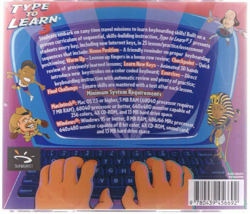

'product title is type to learn product overview is'

In [7]:
example = val_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

example["text"]

In [43]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"],
                                  text=item["text"],
                                  truncation=True,
                                  padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
       
        return encoding

from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")

val_dataset = ImageCaptioningDataset(val_dataset, processor)

In [44]:
# Iterate through the dataset and print the length of each input sequence
indices_to_exclude = [20601, 20602, 32084, 35422, 77578, 77776, 77891,
           77893, 88724, 88783, 88784, 97167, 97168, 98892,
           122296, 125396, 125846, 141298, 149114, 149123, 169166, 172201, 179787,
                      179788, 179789, 179790, 180489]


for idx in tqdm(indices_to_exclude):
    sample = val_dataset[idx]
    # The length of the input_ids tensor indicates the length of the input sequence
    input_ids_length = sample['input_ids'].shape[0]

    if input_ids_length > 512:
        print(f"Length of input sequence {idx}: {input_ids_length}")
        generated_caption = processor.batch_decode(sample['input_ids'], skip_special_tokens=True)

### Saving the test dataset

In [57]:
test_data_path = root +'test/'

test_dataset = load_dataset("imagefolder", data_dir=test_data_path, split='train')

print("Test Dataset:")
print(test_dataset)

Resolving data files:   0%|          | 0/183121 [00:00<?, ?it/s]

Computing checksums:  26%|##6       | 48042/183121 [00:05<00:14, 9608.19it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Test Dataset:
Dataset({
    features: ['image', 'text'],
    num_rows: 183120
})


In [58]:
if not os.path.exists(root + 'test_dataset_version_6/'):
    os.mkdir(root + 'test_dataset_version_6/')
    
test_dataset.save_to_disk(root + 'test_dataset_version_6/')

Saving the dataset (0/11 shards):   0%|          | 0/183120 [00:00<?, ? examples/s]